In [1]:
import glob,time
import pylab as pl
import numpy as np
import matplotlib
import astropy.io.fits as fits
import matplotlib.pyplot as plt

from   astropy.table import Table, vstack, join
from   desimodel.focalplane.geometry import xy2radec 
from   desimodel.io import load_fiberpos 
from   desitarget.geomask import circles 
from   desitarget.sv3.sv3_targetmask import desi_mask, bgs_mask, mws_mask 

import healpy as hp
import pandas as pd
import matplotlib.gridspec as gridspec
from astropy.io import fits as fits
from astropy import constants as const
from astropy import units as u
from astropy.table import QTable

import math

import sys
sys.path.append('/global/homes/l/lbigwood/LSS/py')
import LSS
import LSS.SV3
import LSS.SV3.cattools as cattools

from desitarget.geomask import get_imaging_maskbits 

nside = 32
orig_density_per_deg = 2500 #random

#files
sv3_randoms = '/global/cfs/cdirs/desi/survey/catalogs/SV3/LSS/random0/rancomb_brightwdup_Alltiles.fits'
main_survey_randoms = '/global/cfs/cdirs/desi/target/catalogs/dr9/0.49.0/randoms/resolve/randoms-1-0.fits'

In [2]:
#this is just the function from cattools ive used before, needed because we want to select one rosette
def tile2rosette(tile):
    if tile < 433:
        return (tile-1)//27
    else:
        if tile >= 433 and tile < 436:
            return 13
        if tile >= 436 and tile < 439:
            return 14
        if tile >= 439 and tile < 442:
            return 15
        if tile >= 442 and tile <=480:
            return (tile-442)//3
            
        if tile > 480:
            return tile//30    
    return 999999 #shouldn't be any more?

In [3]:
#again finding bright and completed tiles from sv3 list of tiles and adding a column for rosette
tiles = Table.read('/global/cscratch1/sd/mjwilson/S4MOCK/tiles-sv3.ecsv')
tiles = tiles[(tiles['STATUS'] == 'done') & (tiles['PROGRAM']=='BRIGHT')]
tiles['ROSETTE'] = np.array([tile2rosette(x) for x in tiles['TILEID']])
tiles

TILEID,PASS,RA,DEC,PROGRAM,IN_DESI,PRIORITY,STATUS,EBV_MED,DESIGNHA,DONEFRAC,AVAILABLE,ROSETTE
int64,int32,float64,float64,str6,bool,float64,str8,float32,float32,float32,bool,int64
12,0,150.04,2.286,BRIGHT,True,0.000e+00,done,0.022782475,0.00,1.0455,False,0
13,1,150.061,2.069,BRIGHT,True,0.000e+00,done,0.023243327,0.00,1.1505,False,0
14,2,150.212,2.226,BRIGHT,True,0.000e+00,done,0.022683823,0.00,1.0456,False,0
15,3,149.98,2.171,BRIGHT,True,0.000e+00,done,0.023039486,0.00,1.1052,False,0
16,4,150.187,2.099,BRIGHT,True,0.000e+00,done,0.023041949,0.00,1.0776,False,0
17,5,150.106,2.302,BRIGHT,True,0.000e+00,done,0.022638734,0.00,1.1865,False,0
18,6,149.993,2.237,BRIGHT,True,0.000e+00,done,0.022844847,0.00,1.4589,False,0
19,7,150.128,2.065,BRIGHT,True,0.000e+00,done,0.023041053,0.00,1.3565,False,0
20,8,150.17,2.28,BRIGHT,True,0.000e+00,done,0.02263027,0.00,1.1368,False,0


In [4]:
#printing rosettes in sv3
np.unique(tiles['ROSETTE'].data)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19])

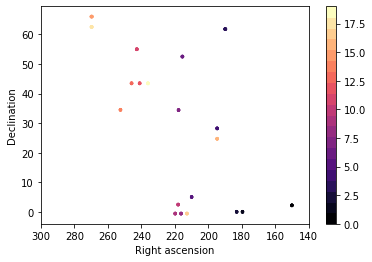

In [5]:
#plotting tile ra and dec and colour coding by rosette
cmap = matplotlib.cm.get_cmap("magma", 20)

pl.scatter(tiles['RA'], tiles['DEC'], marker='.', lw=0.0, c=tiles['ROSETTE'], cmap=cmap)
pl.xlim(300., 140.)
pl.xlabel('Right ascension')
pl.ylabel('Declination')
pl.colorbar()

In [6]:
#making full sv3 ledger 
ledger = vstack([Table.read(x) for x in glob.glob('/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALLEDGER/bright/*')])

In [7]:
#checking when priority init matches priority in total ledger
np.mean(ledger['PRIORITY_INIT'] == ledger['PRIORITY'])

0.6553668048332207

In [8]:
#update ledger so only have targets where initial priority is same as priority, i guess like first run 
ledger    = ledger[ledger['PRIORITY_INIT'] == ledger['PRIORITY']]

In [9]:
#ledger is apparently long 
len(ledger) / 1.e6

1.448765

In [10]:
#list of tile ids for the rosette 15 - this is rosette we are working with for now 
tids      = tiles['TILEID'].data[tiles['ROSETTE'] == 15]
tids

array([417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427])

In [11]:
#root for fibre assign files 
root      = '/global/cscratch1/sd/mjwilson/S4MOCK/SV3REAL/SV3REALASSIGN/'

In [12]:
#list of all the sv3 nights so far i think
nights    = [x.split('/')[-1] for x in sorted(glob.glob(root + '/*'))]
nights.remove('SV3.ecsv')
nights

['20210405',
 '20210407',
 '20210408',
 '20210409',
 '20210410',
 '20210411',
 '20210412',
 '20210413',
 '20210414',
 '20210415',
 '20210416',
 '20210417',
 '20210418',
 '20210419',
 '20210420',
 '20210422',
 '20210429',
 '20210430',
 '20210501',
 '20210502',
 '20210503',
 '20210504',
 '20210505',
 '20210506',
 '20210507',
 '20210508',
 '20210509',
 '20210510',
 '20210511',
 '20210512',
 '20210513',
 '20210514',
 '20210518',
 '20210521',
 '20210529']

In [13]:
#loads positions of all the fibers
fp            = load_fiberpos() 

In [14]:
#for fiber circles on plot 
patrol_radii  = 1.48/60. # degrees 

In [15]:
#loop through nights and tiles targeted
#in order to get a list of targets that have been assigned and available 
#remember this is just for rosette 15 

assigned_targets =[]
avail_targets =[]
ra_avail = []
dec_avail = []
ra_assigned = []
dec_assigned = []

for night in nights:
    fbas      = sorted(glob.glob(root + '/' + night + '/fba-*.fits'))
    ts        = np.array([x.split('/')[-1].replace('.fits','').replace('fba-','') for x in fbas]).astype(np.int64)
    
    ts        = ts[np.isin(ts, tids)]
    
    print(night, ts)
    
    if len(ts) == 0:
        continue

    fig, axes = plt.subplots(len(ts), 1, figsize=(20*len(ts),20))

    if len(ts) == 1:
        axes  = np.array([axes])

    for i, tid in enumerate(ts):
        fpath = root + '/' + night + '/fba-{:06d}.fits'.format(tid)
        tpath = root + '/' + night + '/{:06d}-targ.fits'.format(tid)

        tra   = fits.open(fpath)[1].header['TILERA']
        tdec  = fits.open(fpath)[1].header['TILEDEC']
        
        #not sure why we open targ as don't use it 
        targ  = Table.read(tpath)
        fba   = Table.read(fpath, hdu='FASSIGN')
        ftarg = Table.read(fpath, hdu='FTARGETS')
        favl  = Table.read(fpath, hdu='FAVAIL')
    
        # Only keep targets available to a good fiber. 
        good_fib = (fba['FIBERSTATUS']==0)
        favl  = favl[np.isin(favl['LOCATION'], fba['LOCATION'].data[good_fib])] 
    
        favl  = join(favl, ledger, keys='TARGETID', join_type='left')
        fba   = join(fba,  ledger, keys='TARGETID', join_type='left')
        
        # Keep only the matches.  Not really sure what this is doing?
        favl  = favl[~favl['RA'].mask]

        # keep good fibres only for fba too (did it for favl above)
        fba   = fba[fba['FIBERSTATUS'] == 0]

        # Keep available only if unassigned.  Got rid of this line for now as calculating efficiencies, not plotting
        #favl  = favl[~np.isin(favl['TARGETID'].data, fba['TARGETID'])]
        
        gloc  = fba['LOCATION']
        
        # Keep only BGS Bright
        fba   = fba[(fba['SV3_BGS_TARGET'].data & bgs_mask['BGS_BRIGHT']) != 0] 
        favl  = favl[(favl['SV3_BGS_TARGET'].data & bgs_mask['BGS_BRIGHT']) != 0] 
        
        plt.sca(axes[i])
 
        ra, dec = xy2radec(tra, tdec, fp["X"], fp["Y"])

        #plot fibers
        circles(ra[ np.isin(fp['LOCATION'], gloc)], dec[ np.isin(fp['LOCATION'], gloc)], s=patrol_radii, alpha=0.1)  
        circles(ra[~np.isin(fp['LOCATION'], gloc)], dec[~np.isin(fp['LOCATION'], gloc)], s=patrol_radii, alpha=0.1, c='r')
    
        # add targets to my lists so have them all for rosette 15
        avail_targets.append(favl['TARGETID'].data)
        assigned_targets.append(fba['TARGETID'].data)
        
        ra_avail.append(favl['RA'].data)
        dec_avail.append(favl['DEC'].data)
        ra_assigned.append(fba['RA'].data)
        dec_assigned.append(fba['DEC'].data)
        
        # Plot targets available to a good fiber.
        pl.plot(favl['RA'].data, favl['DEC'].data, marker='x', lw=0.0, markersize=4, c='k', alpha=0.5)

        # Plot targets assigned to a good fiber.
        pl.plot(fba['TARGET_RA'].data, fba['TARGET_DEC'].data, marker='.', lw=0.0, markersize=2, c='k')
            
    pl.xlabel('Right ascension [deg.]')
    pl.ylabel('Declination [deg.]')        
    pl.title('Tiles {} on night {}'.format(ts, night))
    #pl.show()
    pl.clf()

20210405 [417]


20210407 []
20210408 []
20210409 []
20210410 [418]


20210411 [419]


20210412 []
20210413 []
20210414 []
20210415 [420]


20210416 []
20210417 [421]


20210418 []
20210419 []
20210420 [422]


20210422 [423]


20210429 [424]


20210430 []
20210501 [425]


20210502 []
20210503 []
20210504 []
20210505 []
20210506 []
20210507 []
20210508 [426]


20210509 []
20210510 []
20210511 []
20210512 []
20210513 []
20210514 []
20210518 []
20210521 []
20210529 [427]


<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

<Figure size 1440x1440 with 0 Axes>

In [16]:
#number of pixels on sphere and pixel area - we want to be 0.1 deg so have adjusted nside but might need to increase
nside =128
npix = hp.nside2npix(nside)
pixel_area = hp.nside2pixarea(nside,degrees=True)

print(pixel_area)

0.2098234113027917


In [17]:
#sorting out lists so are one big array, instead of seperating tiles 

#overall_eff = len(assigned_targets)/len(avail_targets)
ra_avail = np.concatenate(ra_avail)
dec_avail = np.concatenate(dec_avail)
ra_assigned = np.concatenate(ra_assigned)
dec_assigned = np.concatenate(dec_assigned)

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


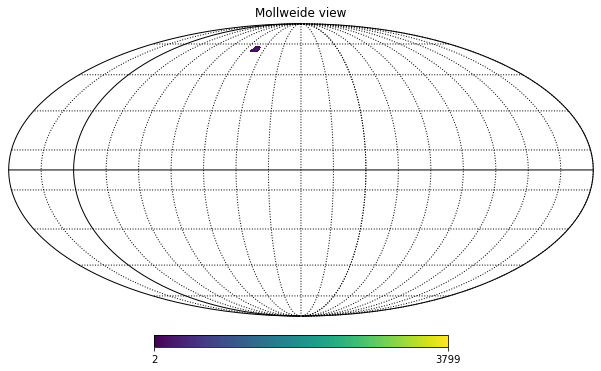

In [18]:
#finding healpixels of assigned targets 

theta = np.pi / 2. - np.radians(np.array(dec_assigned))
phi = np.radians(np.array(ra_assigned))

#indices of pixels with non-zero density, unorganised list
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
assigned_filled_pixel_index, assigned_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
assigned_no_targets = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
assigned_no_targets[assigned_filled_pixel_index] = assigned_targets_per_pixel 
assigned_no_targets[assigned_no_targets == 0] = np.NaN 

#mollview map of pixels
hp.mollview(assigned_no_targets,nest=True,rot=(220, 0.0, 0.0), badcolor='white')
hp.graticule(dpar=5, dmer=5) 

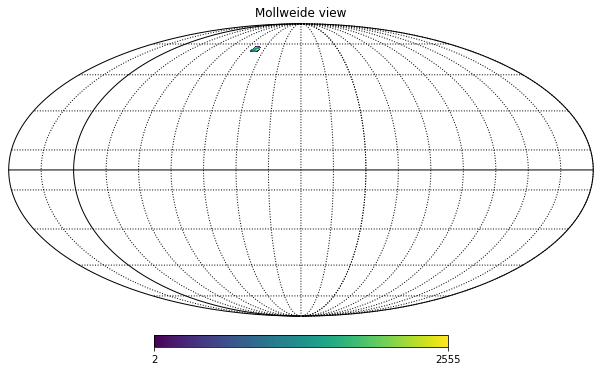

In [19]:
#similarly finding healpixels of available targets 

theta = np.pi / 2. - np.radians(np.array(dec_avail))
phi = np.radians(np.array(ra_avail))

#indices of pixels with non-zero density, unorganised list
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
avail_filled_pixel_index, avail_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
avail_no_targets = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
avail_no_targets[avail_filled_pixel_index] = avail_targets_per_pixel 
avail_no_targets[avail_no_targets == 0] = np.NaN 

#mollview map of pixels
hp.mollview(avail_no_targets,nest=True,rot=(220, 0.0, 0.0), badcolor='white')
hp.graticule(dpar=5, dmer=5) 

In [20]:
#open sv3 randoms

f = fits.open(sv3_randoms)
random=f[1].data

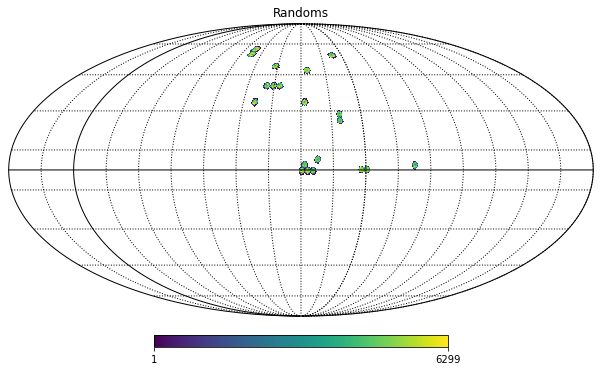

In [21]:
#Find healpixels of randoms.  This is just so we can calculate filling factors to correct the ledger below.  
#note that these randoms havent gone through the BGS imaging cuts.

theta = np.pi / 2. - np.radians(random['DEC'].data)
phi = np.radians(random['RA'].data)

#indices of pixels with non-zero density, unorganised list
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
target_pixel_density = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
target_pixel_density[filled_pixel_index] = filled_targets_per_pixel 
target_pixel_density[target_pixel_density == 0] = np.NaN 

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='Randoms')
hp.graticule(dpar=5, dmer=5) 
    
#correct pixel area based on actual vs expected density 
exp_density_per_pixel = pixel_area * orig_density_per_deg
filling_factor = target_pixel_density/exp_density_per_pixel
corr_pixel_area = pixel_area * filling_factor 

Text(0.5, 0, 'Random filling factor')

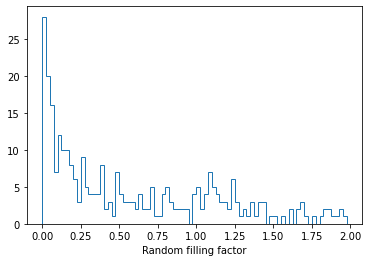

In [22]:
#histogram of filling factor.  This might be problematic (why do we get 2s) 

_ = plt.hist(filling_factor, bins=np.arange(0.0, 2.0, 0.025), histtype='step')
plt.xlabel('Random filling factor')

/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:541: UserWarning: 0.0 180.0 -180.0 180.0
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:656: UserWarning: The interval between parallels is 20 deg 0.00'.
  warnings.warn(
/global/common/software/desi/cori/desiconda/20200801-1.4.0-spec/conda/lib/python3.8/site-packages/healpy/projaxes.py:664: UserWarning: The interval between meridians is 20 deg 0.00'.
  warnings.warn(


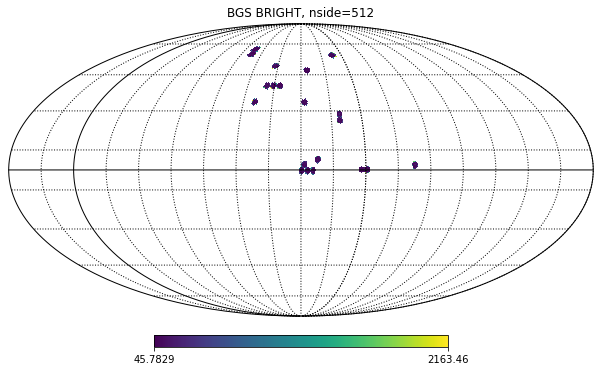

In [23]:
#Now can calculate the target density of the real ledger, using the corrected pixel area from above

theta = np.pi / 2. - np.radians(ledger['DEC'].data[ledger['PRIORITY'].data==102100])
phi = np.radians(ledger['RA'].data[ledger['PRIORITY'].data==102100])

#indices of pixels with non-zero density, unorganised list.
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

#indice of filled pixels and corrosponding targets in pixel
filled_pixel_index, filled_targets_per_pixel = np.unique(all_pixel_indices, return_counts=True) 

#no. targets per pixel, initially 0 
targets_per_pixel = np.zeros(hp.nside2npix(nside))

#update no. targets per pixel 
targets_per_pixel[filled_pixel_index] = filled_targets_per_pixel
targets_per_pixel[targets_per_pixel == 0] = np.NaN 

#get rid of low density healpixels
targets_per_pixel[(filling_factor < 0.5)] = np.NaN 

target_pixel_density = targets_per_pixel/corr_pixel_area

#mollview map of pixels
hp.mollview(target_pixel_density,nest=True,rot=(220, 0.0, 0.0), badcolor='white',title='BGS BRIGHT, nside=512')
hp.graticule(dpar=5, dmer=5) 

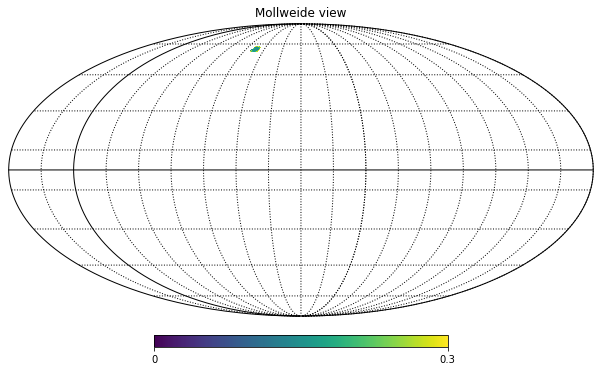

In [24]:
#Now going back to the sv3 randoms, we again put them all in healpixels 
#Then we assign healpixels the fibre assignment efficiency
#We then crete allocated_eff, which goes back and assigns each target the efficiency of that healpixel

theta = np.pi / 2. - np.radians(random['DEC'].data)
phi = np.radians(random['RA'].data)

#indices of pixels with non-zero density, unorganised list
all_pixel_indices = hp.ang2pix(nside, theta, phi,nest=True, lonlat=False)

random_map = np.zeros(hp.nside2npix(nside))
random_map[all_pixel_indices] = assigned_no_targets[all_pixel_indices]/avail_no_targets[all_pixel_indices]
random_map[random_map == 0] = np.NaN 

allocated_eff = []

for i in range(len(all_pixel_indices)):
    allocated_eff.append(random_map[all_pixel_indices[i]])
    
allocated_eff = np.array(allocated_eff)

hp.mollview(random_map,nest=True,rot=(220, 0.0, 0.0), badcolor='white',min=0,max=0.3)
hp.graticule(dpar=5, dmer=5) 

1.0


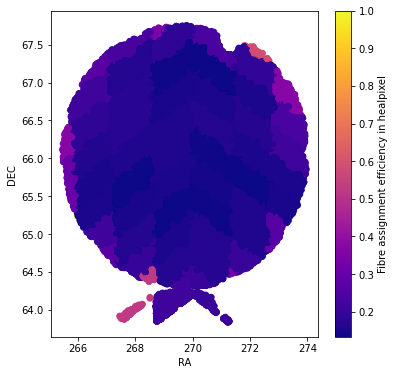

In [25]:
#this is a plot of ra vs dec for randoms that have been allocated an efficiency, i.e those in tiles in rosette 15
#it is maybe concerning that if you look up the max efficiency i.e:
x=allocated_eff[~np.isnan(allocated_eff)]
print(x[np.argmax(x)])
#you get 1???

from matplotlib.pyplot import colorbar

plt.figure(figsize=(6,6))
plt.scatter(random['RA'][~np.isnan(allocated_eff)],random['DEC'][~np.isnan(allocated_eff)],c=allocated_eff[~np.isnan(allocated_eff)],cmap = 'plasma')
plt.xlabel('RA')
plt.ylabel('DEC')

cbar = colorbar(label ='Fibre assignment efficiency in healpixel' )


Text(0.5, 0, 'Target density')

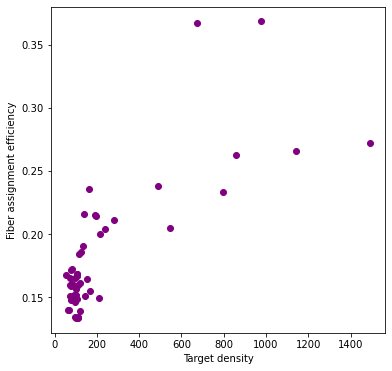

In [27]:
#now we create plot of sv3 target density against fiber assignment efficiency for rosette 15
#use avail one because assigned has an extra healpixel of targets not avail 

eff_array = random_map[avail_filled_pixel_index]
r15_target_density = target_pixel_density[avail_filled_pixel_index]

plt.figure(figsize=(6,6))
plt.scatter(r15_target_density,eff_array,color='purple')
plt.ylabel('Fiber assignment efficiency')
plt.xlabel('Target density')

# Done.